## Process
### Requirement: opencv-contrib-python (aruco)
#### windows
```cmd
pip install urdf_parser_py opencv-contrib-python --user
```
#### linux
```bash
pip3 install urdf_parser_py opencv-contrib-python --user
```

### Start Bullet Server with ControlHubPlugin
#### windows
```cmd
rnb-control\BulletSimControl\x64\Release\BulletSimControl.exe
```
#### linux
```bash
rnb-control/BulletSimControl/bin/BulletSimControl
```

In [1]:
from bullet_sim_client import *
from utils.trajectory_client.trajectory_client import TrajectoryClient
from utils.web_client import WebClient

## Connect and set physics

In [2]:
init_bullet_sim()

### Load model

In [3]:
ROBOT_TYPE = RobotType.KUKA_IIWA
pc = BulletControlHubClient(get_urdf_path(ROBOT_TYPE), xyz=(0,0,0))

### initialize control hub

In [4]:
pc.set_control_hub() ## Init ControlHub

### Initialize state

In [5]:
if ROBOT_TYPE==RobotType.INDY7:
    Q0 = [0, 0, -np.pi / 2, 0, -np.pi / 2, 0] # for indy
else:
    Q0 = [0, np.pi / 8, 0, -np.pi / 4,  0, np.pi / 8, 0] # for iiwa
Q2 = np.add(Q0, np.pi/4)

pc.initialize_state(Q=Q0)

## Marker detection

In [6]:
from bullet_cv import *

In [7]:
mid = 0  # marker id
Tbm = SE3(np.identity(3), (0.5,0,0.5))  # marker position
marker_dim = 0.1  # marker dimension

# add marker on scene
gid_list = add_marker(mid, Tbm, marker_dim) 

In [8]:
# calculate cam pose
Tbc = calc_Tbc(cam_pos=[1,0.5,1], cam_tar=Tbm[:3,3].tolist())
# get camera image
color, depth, cameraMatrix = get_cam_images(Tbc)
# show camera coordinates
show_axis(*T2xyzquat(Tbc))

(66, 67, 68)

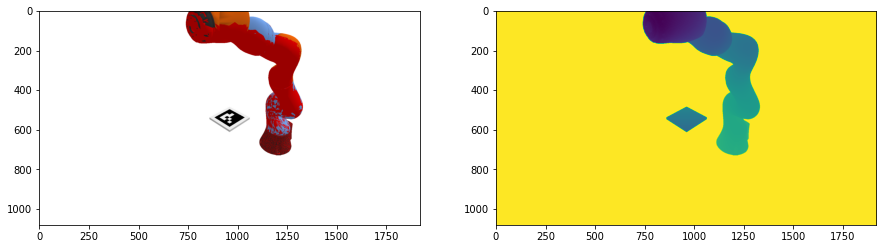

In [9]:
## show color and depth map
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(color)
plt.subplot(1,2,2)
plt.imshow(depth)

## Detect and draw marker

In [10]:
# convert to RGB, uint8
color_u8 = color[:,:,:3].astype(np.uint8) 

# detect markers
corners, ids, ret = aruco.detectMarkers(color_u8, ARUCO_DICTIONARY)

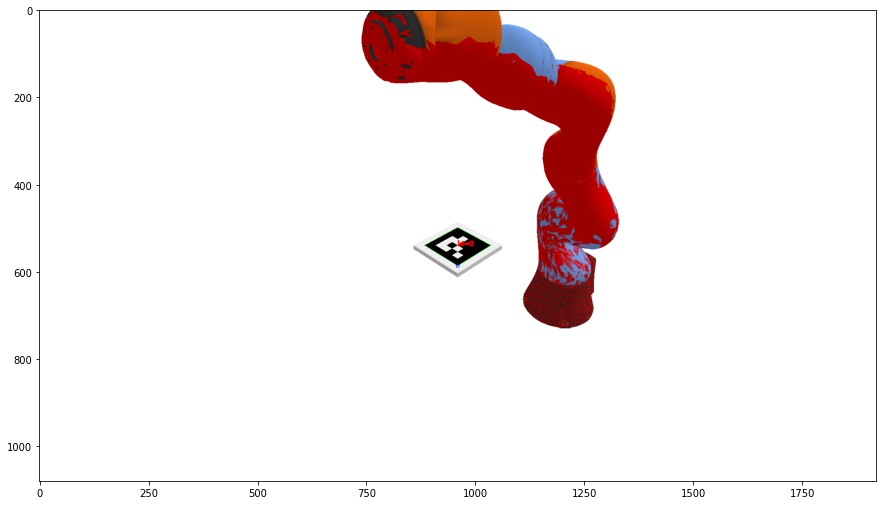

In [11]:
# draw detected markers
marks_drawn = aruco.drawDetectedMarkers(np.copy(color_u8), corners, ids)
plt.figure(figsize=(15,10))
plt.imshow(marks_drawn)

## Estimate marker pose

In [12]:
# Get the rotation and translation vectors
rvecs, tvecs, obj_points = cv2.aruco.estimatePoseSingleMarkers(
    corners, marker_dim, cameraMatrix, np.array([0.0]*5))

# Get marker-cam transformation matrix
idx = np.where(ids==mid)[0][0]
R, jac = cv2.Rodrigues(rvecs[idx])
P = tvecs[idx][0]
Tcm = SE3(R, P)

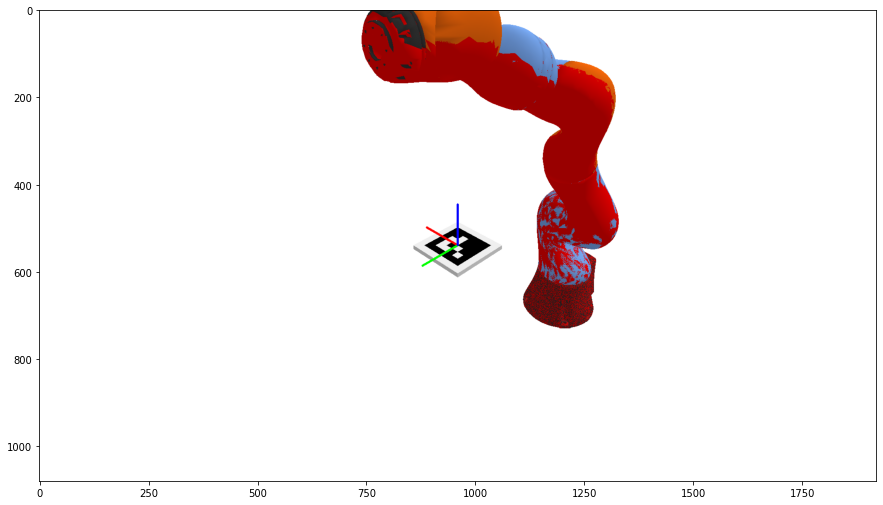

In [13]:
# Draw detected coords
plt.figure(figsize=(15,10))
bgr_u8 = cv2.cvtColor(color_u8, cv2.COLOR_RGB2BGR)
aruco.drawAxis(bgr_u8, cameraMatrix, np.zeros(5),
                          rvecs[idx], tvecs[idx], 0.1)
plt.imshow(bgr_u8[:,:,[2,1,0]])

### Transform to world coordinates and draw axis on simulation

In [14]:
cam_flip = SE3(Rot_axis(1,np.pi), [0]*3) # camera coordinate is fliped in bullet
Tbm = matmul_series(Tbc, cam_flip , Tcm) # marker pose in world coords
show_axis(*T2xyzquat(Tbm))

(69, 70, 71)

## Test pick motion

In [15]:
traj_client = TrajectoryClient("localhost")

### calculate pick point

In [16]:
# calculate pick pose
Tbp = np.matmul(Tbm, SE3(Rot_axis(2, np.pi), [0,0,0.1]))
# show pick point
ax_ids = show_axis(*T2xyzquat(Tbp))

## Calculate task traj

In [17]:
from utils.algebra import *

In [18]:
dyn_params = pc.update_state()
P0 = np.array(dyn_params.p)
P1 = np.concatenate([Tbp[:3,3], list(reversed(Rot2zyx(Tbp[:3,:3])))])
DUR= 3

In [19]:
## Calculate s-curve trajectory in task space
se3_alg = Combined([Euclidean(3), RotationUVW()])


N_div = 100
dp = se3_alg.diff_in_alg(P0, [P1])

# make double-S curve in algebra
dp_traj = dp * (
    np.sin(np.pi * (np.arange(N_div,dtype=float)[:,np.newaxis] / N_div - 0.5)) + 1) / 2

In [20]:
## show sampled points
P_list = se3_alg.add_from_alg(P0, dp_traj[::20])
for P_i in P_list:
    ax_ids += show_axis(*T2xyzquat(
        SE3(Rot_zyx(*list(reversed(P_i[3:]))), P_i[:3])))

## Calculate joint traj

In [21]:
from urdf_parser_py.urdf import URDF

urdf_content = URDF.from_xml_file(get_urdf_path(ROBOT_TYPE))
link_names = get_link_names(urdf_content)
joint_names = get_joint_names(urdf_content)
base_link, tip_link = link_names[0], link_names[-1]

In [22]:
Q0 = np.array(dyn_params.q)
dp_list = dp_traj[1:]-dp_traj[:-1]
Qi = np.copy(Q0)
joint_traj = []
for dp_i in dp_list:
    J = get_jacobian(
        tip_link, urdf_content, Qi, joint_names, ref_link=base_link)
    Qi += np.matmul(np.linalg.pinv(J), dp_i)
    joint_traj.append(np.copy(Qi))
Qfin = Qi

### test motion

In [23]:
start_simulation_thread() # ON

In [24]:
traj_client.move_joint_traj(joint_traj)

In [25]:
stop_simulation_thread() # OFF

[INFO] simulation thread stopped


### remove marker

In [26]:
for gid in ax_ids:
    pb.removeBody(gid)

## Unload Robot

In [27]:
pc.unload()